In [2]:
from gutenbergpy.gutenbergcache import GutenbergCache, GutenbergCacheTypes
import os
import json
import pandas as pd
import numpy as np
import pickle as pkl

In [3]:
# Constants
NUM_AUTHORS = 50
WORKS_PER_AUTHOR = 5
CHUNKS_PER_WORK = 10
CHUNK_LENGTH = 50

np.random.seed(699)

## Exploring the Data Distribution of Project Gutenberg
Our first step in developing a sampling approach is to determine what metadata is available and how best to create a rich, diverse sample for language modeling. We start by initializing the cache and looking at the schema:

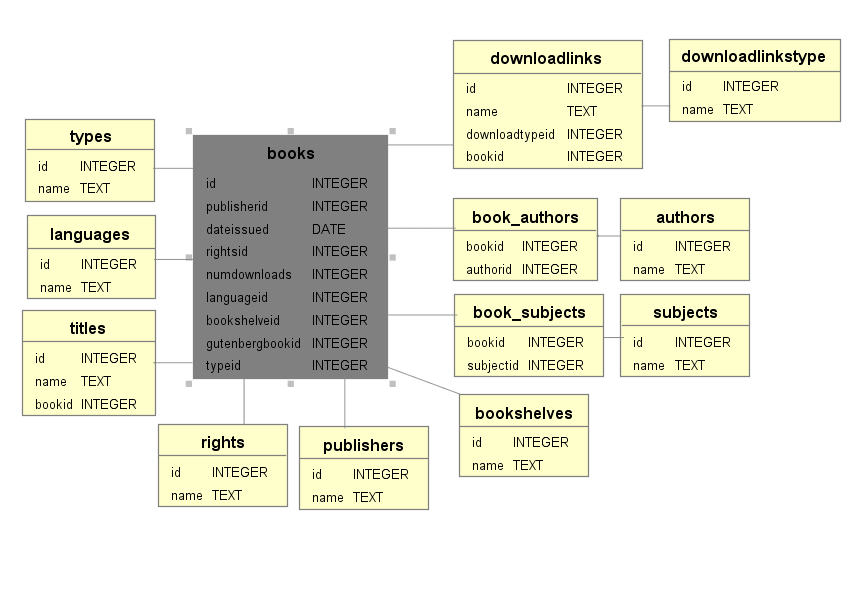

In [4]:
cache  = GutenbergCache.get_cache()
from IPython.display import Image
Image(filename='sqlitescheme.png') 

#### Types of Media

We want our sample to consist solely of text based media; however, the type field is not well maintained for the majority of the works on project gutenberg.

In [11]:
types = [t for t in cache.native_query("SELECT id from books where gutenbergbookid = 15")]


[t for t in cache.native_query("SELECT * from titles where bookid = {}".format(types[0][0]))]

[(69193, 'Moby-Dick; or, The Whale', 65078)]

#### Gathering Bookshelves

Books on Project Gutenberg are sorted into collections called bookshelves; there are Main Categories each with their own Bookshelf ID; we are interested in English Language (Language.id = 1) text (type.id = 5) texts. However, it also seems that bookshelves themselves are not well populated in the metadata either, meaning a new approach is warranted.

In [5]:
shelves = [sh for sh in cache.native_query(
        "SELECT * FROM (" +
        "SELECT bs.id, bs.name, COUNT(b.id) as BOOK_COUNT FROM " +
        "(SELECT DISTINCT id, name FROM bookshelves) as bs " +    
        "RIGHT JOIN " + 
        "(SELECT id, bookshelveid, languageid, typeid FROM books " + 
        "WHERE languageid=1) as b " +
        "ON bs.id=b.bookshelveid) as bbs " +
        "GROUP BY bbs.id, bbs.name " + 
        "ORDER BY BOOK_COUNT DESC;")]

shelves

[(1, 'The Great Round World And What Is Going On In It', 56673)]

#### Subjects vs. Book Subjects In Project Gutenberg

In [ ]:

# Retrieves all subjects

subjects = [s for s in cache.native_query(
    "SELECT bs.subjectid, s.name, count(bs.bookid) AS book_count FROM book_subjects AS bs \
    LEFT JOIN subjects AS s \
    ON s.id = bs.subjectid \
    GROUP BY s.id, s.name \
    ORDER BY book_count DESC \
    LIMIT 25;")]

# See the script "subjectid.sql" for a full listing of the actual subject names
subjects

[(44, 'PS', 11113),
 (10, 'PR', 10009),
 (13, 'PZ', 7282),
 (16, 'PQ', 4843),
 (28, 'PT', 2956),
 (80, 'Science fiction', 2938),
 (14, 'Short stories', 2748),
 (2, 'AP', 2583),
 (71, 'Fiction', 1979),
 (46, 'DA', 1663),
 (105, 'Adventure stories', 1475),
 (146, 'PH', 1379),
 (18, 'PN', 992),
 (79, 'DC', 961),
 (308, 'Historical fiction', 947),
 (91, 'DS', 943),
 (30, 'Conduct of life -- Juvenile fiction', 876),
 (158, 'Love stories', 858),
 (291, 'D501', 827),
 (192, 'Detective and mystery stories', 818),
 (51, 'Man-woman relationships -- Fiction', 809),
 (197, 'BX', 745),
 (29, 'Poetry', 681),
 (68, 'QH', 670),
 (242, 'QL', 670)]

#### Querying a Subject

Some of the subject titles aren't particularly informative; in order to get a better picture of what each subject is, we can query them individually to retrieve top downloads for each subject:  

In [75]:
top25 = [s for s in cache.native_query("SELECT typeid FROM BOOKS")]

# See the script "subjectid.sql" for a full listing of the actual subject names

top25

[(-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (-1,),
 (

In [7]:
# Top N Downloads for subject ID:

top25 = [s for s in cache.native_query(
    "SELECT bs.subjectid, b.name, b.numdownloads FROM \
    (SELECT * FROM books \
     LEFT JOIN titles AS T \
     ON T.bookid = books.id) AS b \
    LEFT JOIN book_subjects AS bs \
    ON b.id = bs.bookid and bs.subjectid=44 \
    ORDER BY b.numdownloads DESC \
    LIMIT 25;")]

# See the script "subjectid.sql" for a full listing of the actual subject names

top25

[(None, 'Romeo and Juliet', 197127),
 (None, 'A Room with a View', 167726),
 (None, 'Middlemarch', 165079),
 (44, 'Little Women; Or, Meg, Jo, Beth, and Amy', 152480),
 (44, 'Moby Dick; Or, The Whale', 148386),
 (None, 'The Enchanted April', 147692),
 (44, 'The Blue Castle: a novel', 147236),
 (None, 'The Complete Works of William Shakespeare', 147074),
 (None, 'Cranford', 143503),
 (None, 'The Adventures of Ferdinand Count Fathom — Complete', 141299),
 (None, 'The Expedition of Humphry Clinker', 139335),
 (None, 'The Adventures of Roderick Random', 137522),
 (None, 'History of Tom Jones, a Foundling', 131062),
 (None, 'Twenty Years After', 128560),
 (None, 'Vingt ans après. English', 128560),
 (None, 'My Life — Volume 1', 128316),
 (None, 'Frankenstein; Or, The Modern Prometheus', 75145),
 (None, 'Pride and Prejudice', 68103),
 (None, 'Alice in Wonderland', 31948),
 (None, "Alice's Adventures in Wonderland", 31948),
 (44, 'The Great Gatsby', 25354),
 (44, 'The Yellow Wallpaper', 24783)

#### Querying an Author

In our analysis, we intend to have the model attempt to learn to detect different writers for based on their style of writing; in order to do this, we need a good sample of writers for each subject.

In [8]:
topAuthors = [s for s in cache.native_query(
    "SELECT a.authorid, a.name, count(a.bookid) as book_count from \
    (SELECT * from authors \
    LEFT JOIN book_authors \
    ON id = authorid) as a \
    LEFT JOIN \
    (SELECT * FROM books \
    WHERE languageid = 1) as b \
    ON b.id = a.bookid \
    GROUP BY a.id, a.name \
    HAVING book_count >= 5 \
    ORDER BY book_count DESC;")]

# We have an 80 / 20 rule for sampling; at least 10 passages per author, and 
# Note this is the authors with the most books, not the authors with most downloads
# Furthermore, there are many repeats in the list of authors; Shakespeare appears 3 times, Jules Verne 4
pd.DataFrame(topAuthors).to_csv("top_authors.csv")

# TODO:
# 1 ) Write Sampling Scheme At most 1 hour
# np.random.choice() #What is n? How many authors?

# 2 ) SQL CODE to then generate new 

# 3 ) Combine and consolidate text: Half a day
# Topics
# Authors
# Book Title
# Line Numbers
# And Text

# 4 ) Consolidate and split to train / test

# Bonus: Find better metadata

Notes:
 * No anonymous / (Various) / etc.
 * Key identifiers such as character names e.g. Captain Ahab

Filter for English Authors with enough books to sample
random subset of 5 works
10 samples from each work, 50 lines each
 * Each book has at min 500 lines
 * Every author has 2500 Lines

How many authors?

Issues:
Herman Melville's Moby Dick

Post Sampling:
* Text processing (removing punctuation)
    * Keep punctuation in one dataset -> We want punctuation for tet generation?
    * Strip from the other (learning language, classification, etc.) -> reduce number of tokens

.pkl (pickle)


In [42]:
numAuthors = [s for s in cache.native_query(
    "SELECT COUNT(*) FROM (SELECT a.authorid, a.name, count(a.bookid) as book_count from \
    (SELECT * from authors \
    LEFT JOIN book_authors \
    ON id = authorid) as a \
    LEFT JOIN \
    (SELECT * FROM books \
    WHERE languageid = 1) as b \
    ON b.id = a.bookid \
    GROUP BY a.id, a.name \
    HAVING book_count >= 50 \
    ORDER BY book_count DESC);")]

numAuthors

[(358,)]

In [6]:
allAuthors = [s for s in cache.native_query(
    "SELECT a.authorid, a.name, count(b.id) as book_count from \
    (SELECT * from authors \
    LEFT JOIN book_authors \
    ON id = authorid) as a \
    LEFT JOIN \
    (SELECT * FROM books \
    WHERE languageid = 1 AND typeid = -1) as b \
    ON b.id = a.bookid \
    GROUP BY a.id, a.name \
    HAVING book_count >= 5 \
    ORDER BY book_count DESC;")]

# pd.DataFrame(allAuthors).to_csv("all_authors.csv")

allAuthors

[(1, 'Verschillende', 3478),
 (2, 'Various, Various', 3478),
 (3, 'Various', 3478),
 (125, 'Anonyme', 737),
 (126, 'Anonymous, Anonymous', 737),
 (127, 'Anonymous', 737),
 (1042, 'Bulwer-Lytton, Edward George Earle Lytton, 1st Baron', 218),
 (1043, 'Bulwer, Edward Lytton', 218),
 (1044, 'Lytton, Edward Bulwer', 218),
 (1045, 'Lytton, Edward Bulwer Lytton, Baron', 218),
 (1076, 'Shakspeare, William', 183),
 (1077, 'Shakspere, William', 183),
 (1078, 'Shakespeare, William', 183),
 (3895, 'Ebers, Georg Moritz', 164),
 (3896, 'Ebers, George Moritz', 164),
 (3897, 'Ebers, Georg', 164),
 (85, 'Clemens, Samuel Langhorne', 158),
 (86, 'Twain, Mark (Samuel Clemens)', 158),
 (87, 'Twain, Mark', 158),
 (385, 'Wilson, Margaret', 135),
 (803, 'Parker, Horatio Gilbert', 134),
 (804, 'Parker, Gilbert, Sir, bart.', 134),
 (805, 'Parker, Gilbert', 134),
 (379, 'Oliphant, Margaret Oliphant Wilson', 133),
 (380, 'Mrs. (Margaret) Oliphant', 133),
 (381, 'Olyphant, Mrs.', 133),
 (382, 'Oliphant, M. O. W. (

In [7]:
np.random.seed(699)

allAuthors

author_ids = [a[0] for a in allAuthors]

sampled_authors = np.random.choice(author_ids, size=NUM_AUTHORS)
id_author_map = {a[0]:a[1] for a in allAuthors}
sampled_names = [id_author_map[idx] for idx in sampled_authors]
sampled_names

['Leland, Charles Godfrey',
 'Adair, Cecil',
 'Seaman, Augusta Huiell',
 'Fletcher, Horace',
 'Hatteras, Owen',
 'Mandeville, Bernard',
 'Arnim-Schlagenthin, Countess Elizabeth von',
 'Macduff, J. R. (John Ross)',
 'Thibault, Anatole',
 'King, Basil',
 'Beith, Ian Hay',
 'Burnham, Clara Louise',
 'Proctor, R. A. (Richard Anthony)',
 'Church, Richard William',
 'Ebers, Georg Moritz',
 'Fyfe, H. B. (Horace Bowne)',
 'Gaskell, Mrs.',
 'Du Hausset, Madame',
 'Hogg, James',
 'Graves, Robert',
 'Vinci, Léonard de',
 'Beith, Ian Hay',
 'Rolleston, T.W.',
 'Peck, George Wilbur',
 'Hart, A. B. (Albert Bushnell)',
 'Littlewit, Humphrey',
 'Pain, Thomas',
 'Accum, Frederick',
 'Mulock, Dinah Maria',
 'Hyne, Cutcliffe',
 'MacApp, C.C.',
 'March, Anne',
 'Vambéry, A.',
 'Beck, Lily Moresby Adams',
 'Benson, Mildred Wirt',
 'Pennsylvania Prison Society',
 'Annaeus Seneca, Lucius',
 'Alexander, Mrs.',
 'Reuter, Fritz',
 'Huxley, T. H. (Thomas Henry)',
 'Coffin, Charles C. (Charles Carleton)',
 'Frank

In [9]:
sampled_authors

array([ 8715,  5423,  4297,  4960,  6140, 14712, 15405,  9470,  2890,
        4243,  2073,  6733,  4763, 10473,  3895,  6577,  1154,    72,
       23684, 10993,  4412,  2073, 13042, 15260,  6913, 11351,  6291,
       23062,  2893, 19816, 11886,  2304,  5677,  8154,  1173,  7088,
        5734,  6224, 15081,  1000, 13240, 11037, 16108, 16139,   266,
       10990, 10517,  6087,  4689,  8775])

In [18]:
# Sample Book Ids for Each author
book_sets = []
for author in sampled_authors:

    book_set = [b[0] for b in cache.native_query(
        "SELECT DISTINCT ba.bookid FROM (SELECT bookid FROM book_authors WHERE authorid = {}) AS ba \
         INNER JOIN (SELECT * FROM books WHERE languageid = 1) as b \
         ON b.id = ba.bookid;".format(author)
    )]
    book_sets.append(book_set)


[6041,
 10830,
 13556,
 24566,
 26377,
 28615,
 33690,
 40198,
 40718,
 50380,
 50803,
 58886,
 59543,
 60346]

In [14]:
sampled_authors[0]

8715

In [21]:

author_works = {}

for author_idx, book_set in enumerate(book_sets):
    sampled_works = np.random.choice(book_set, WORKS_PER_AUTHOR, replace = False)
    book_info = [info for info in cache.native_query(
        "SELECT b.id, t.name, b.gutenbergbookid FROM (SELECT DISTINCT id, gutenbergbookid FROM books  \
        WHERE id in {} ) as b \
        LEFT JOIN titles AS t \
        ON t.bookid = b.id;".format(str(tuple(sid for sid in sampled_works))))]
    author_works[author_idx] = book_info
    

In [22]:
book_info

[(43029, 'Okewood of the Secret Service', 2417),
 (45733, 'The Yellow Streak', 9974),
 (49054, 'With our army in Flanders', 68038),
 (69417, 'The Man with the Clubfoot', 15302),
 (70160,
  'Clubfoot the Avenger\r\nBeing some further adventures of Desmond Oakwood, of the Secret Service',
  65416)]

In [71]:
book_info = [info for info in cache.native_query(
        "SELECT b.id, t.name FROM (SELECT DISTINCT id FROM books  \
        WHERE id in {} ) as b \
        LEFT JOIN titles AS t \
        ON t.bookid = b.id;".format(str(tuple(sid for sid in sampled_works))))]


book_info

[(6522, 'Exeter'),
 (7294, 'The Cornish Riviera'),
 (9314, 'Bournemouth, Poole & Christchurch'),
 (9314, 'Bournemouth, Poole and Christchurch'),
 (28230, 'The Heart of Wessex'),
 (36848, 'Our Homeland Churches and How to Study Them')]

In [68]:
author_works[46]

[(6522, 'Exeter'),
 (7294, 'The Cornish Riviera'),
 (9314, 'Bournemouth, Poole & Christchurch'),
 (9314, 'Bournemouth, Poole and Christchurch'),
 (28745, 'Winchester'),
 (36848, 'Our Homeland Churches and How to Study Them')]

In [50]:
with open("sampled_works.json", 'w') as f:
    json.dump(author_works, f)

In [69]:
sampled_works = np.random.choice(book_sets[46], WORKS_PER_AUTHOR, replace = False)

In [29]:
numAuthors = [s for s in cache.native_query(
    "SELECT COUNT() FROM (SELECT b.id, b.languageid from authors as a\
    LEFT JOIN book_authors as ba\
    ON a.id = ba.authorid \
    LEFT JOIN books as b \
    ON b.id = ba.bookid \
    WHERE b.languageid = 1 AND typeid = 5 \
    GROUP BY a.id, a.name);")]

numAuthors

[(38152,)]

In [35]:
numAuthors = [s for s in cache.native_query(
    "SELECT COUNT(*) FROM (SELECT b.id, b.languageid, count(ba.bookid) as book_count from authors as a\
    LEFT JOIN book_authors as ba\
    ON a.id = ba.authorid \
    LEFT JOIN books as b \
    ON b.id = ba.bookid \
    WHERE b.languageid = 1 AND typeid = 5 \
    GROUP BY a.id, a.name \
    HAVING book_count >= 5);")]

numAuthors

[(4866,)]

In [14]:
works = [s for s in cache.native_query(
    "SELECT COUNT(*) FROM (SELECT a.name, count(ba.bookid) AS book_count from authors a\
    LEFT JOIN book_authors ba ON a.id = ba.authorid \
    GROUP BY a.name);")]

works

[(48672,)]

In [17]:
englishBooks = [s for s in cache.native_query(
    "SELECT COUNT(*) FROM (SELECT DISTINCT b.id FROM BOOKS as b \
    WHERE b.languageid = 1);")]

englishBooks

[(56673,)]